In [24]:
import pandas as pd
from pymongo import MongoClient

connection = MongoClient(
    host="research.cassee.dev",
    username="read-shark",
    password="msr2021shark")

db = connection.smartshark_2_1

In [2]:
#print(len(list(db.issue.find())), "total issues")  # --> 163057 db.issue.count() or db.issue.find().count() does not seem to work
#print(len(list(db.issue.find({'issue_type' : {'$exists': True}}))), "issues containing an issue_type field")  # --> 158222
#print(len(list(db.issue.find({'issue_type_verified': {'$exists': True }}, {'issue_type': 1, 'issue_type_verified' : 1}))), # --> 15517
#      "issues containing both issue_type and issue_type_verified")  # note, every issue with issue_type_verified also has an issue_type
#print(len(list(db.issue.find({'issue_type' : {'$exists': True}, 'desc':{'$exists': True}}))), "issues containing an issue_type and description field")  # --> 146662


In [6]:
# Query
data = list(db.issue.aggregate([{
           '$lookup':
             {
               'from': 'people',
               'localField': 'creator_id',
               'foreignField': '_id',
               'as': 'people'
             }},
            {
            '$unwind': '$people'
            },
            {
            '$project': {
                '_id': 1, 
                'external_id': 1, 
                'title': 1, 
                'issue_type': 1, 
                'issue_type_verified': 1, 
                'priority': 1, 
                'status': 1, 
                'created_at': 1,
                'updated_at': 1,
                'resolution': 1, 
                'desc': 1,
                'creator_id': '$people._id',
                'email': '$people.email',
                'name': '$people.name',
                'username': '$people.username'
            }
            }
        ]))

In [7]:
# Convert to dataframe
df = pd.DataFrame(data)

#df = df['issue_type'].dropna()
print(len(df.index))
df.head()

157811


,_id,external_id,title,desc,created_at,updated_at,issue_type,priority,status,creator_id,email,name,username,resolution,issue_type_verified
0,58bfca910ccb2667fe269dd1,ZOOKEEPER-24,Do Application based outstanding request throt...,Moved from SourceForge to Apache.\nhttp://sour...,2008-06-10 21:30:20.234,2008-06-10 21:30:20.234,New Feature,Major,Open,58b938adf04620b395fccf94,phunt@apache.org,Patrick Hunt,phunt,NaN,NaN
1,58bfca920ccb2667fe269dd2,ZOOKEEPER-35,Replay logs,Moved from SourceForge to Apache.\nhttp://sour...,2008-06-10 22:38:04.807,2008-06-10 22:38:04.807,New Feature,Major,Open,58b938adf04620b395fccf94,phunt@apache.org,Patrick Hunt,phunt,NaN,NaN
2,58bfca930ccb2667fe269dd3,ZOOKEEPER-37,WebDAV access to ZooKeeper,Moved from SourceForge to Apache.\nhttp://sour...,2008-06-10 22:41:06.723,2008-06-10 22:41:06.723,New Feature,Major,Open,58b938adf04620b395fccf94,phunt@apache.org,Patrick Hunt,phunt,NaN,NaN
3,58bfca930ccb2667fe269dd4,ZOOKEEPER-46,Clients should check the latencies to the vari...,When ZooKeeper clients and servers are on the ...,2008-06-17 14:56:48.591,2008-06-17 14:57:32.124,Improvement,Major,Open,58b938adf04620b39bfccf95,breed@apache.org,Benjamin Reed,breed,NaN,NaN
4,58bfca940ccb2667fe269dd7,ZOOKEEPER-52,Session ids on the stat cmd information,Currently there is not a way to correlate sess...,2008-06-25 15:34:15.116,2008-06-25 15:34:15.116,Improvement,Minor,Open,58b938adf04620b39bfccf95,breed@apache.org,Benjamin Reed,breed,NaN,NaN


## Issue Types (Verified)

In [8]:
# Combine issue type and issue type verified, such that if there is a verified type we pick that, otherwise keep the original issue type
df['new_issue_type'] = df['issue_type_verified'].combine_first(df['issue_type'])

# drop the old issue types and rename new_issue_type to issue_type
df = df.drop(columns = ['issue_type', 'issue_type_verified'])
df = df.rename(columns={'new_issue_type': 'issue_type'})

In [9]:
# put all issue types in lowercase
df['issue_type'] = df['issue_type'].apply(lambda x: x.lower())
print("All issue type currently present:\n", df['issue_type'].value_counts(dropna=False))

# grouping of values which mean the same but have different labels
feature_equivs = ['improvement', 'new feature', 'wish', 'feature_request', 'brainstorming', 'request', 'proposal']
feature_val = 'feature'
task_equivs = ['sub-task', 'task', 'technical task']
task_val = 'task'
dependency_equivs = ['dependency upgrade', 'dependency']
dep_val = 'dependency'
other_equivs = ['other', 'epic', 'refactoring', 'temp', 'umbrella', 'story', 'blog - new blog request', 'tck challenge', 'it help', 'new jira project', 'access', 'blogs - new blog user account request', 'project', 'outage', 'new tlp ', 'new git repo', 'planned work']
other_val = 'other'

# mainly not sure what to do with: test, documentation, question, epic, refactoring, temp and umbrella

df['issue_type'] = df['issue_type'].apply(lambda val: feature_val if val in feature_equivs else val) 
df['issue_type'] = df['issue_type'].apply(lambda val: task_val if val in task_equivs else val) 
df['issue_type'] = df['issue_type'].apply(lambda val: dep_val if val in dependency_equivs else val) 
df['issue_type'] = df['issue_type'].apply(lambda val: other_val if val in other_equivs else val) 

print("\nCombined issue types:\n", df['issue_type'].value_counts(dropna=False))

All issue type currently present:
 bug                                      81227
improvement                              42197
new feature                               9585
sub-task                                  9501
task                                      8436
test                                      1739
wish                                      1397
other                                     1227
documentation                             1080
feature_request                            549
question                                   310
dependency upgrade                         153
epic                                       133
refactoring                                 92
story                                       56
temp                                        31
umbrella                                    24
brainstorming                               20
dependency                                  18
blog - new blog request                      6
technical task           

### Status

In [10]:
print("Initial unique status values\n", df['status'].value_counts(dropna=False))

# All issues have a statement (i.e. no nan values), interestingly blocked only occurs twice
# We'll only look at closed and resolved issues
df = df[(df['status'] == 'Closed') | (df['status'] == 'Resolved')]

print("\nFiltered status\n", df['status'].value_counts(dropna=False))

Initial unique status values
 Closed             80826
Resolved           47778
Open               26772
Patch Available     1106
Reopened             706
In Progress          621
Blocked                2
Name: status, dtype: int64

Filtered status
 Closed      80826
Resolved    47778
Name: status, dtype: int64


### Resolution

In [11]:
print("Initial unique resolution values:\n", df['resolution'].value_counts(dropna=False))

# grouping of values which mean the same but have different labels
resolved_equivs = ['Fixed', 'Done', 'Not A Bug', 'Resolved', 'Workaround', 'Works for Me', 'Delivered', 'Implemented', 'Staged']
resolved_val = 'Resolved'
unresolved_equivs = ["Won't Fix", 'Auto Closed', "Won't Do", "Abandoned", 'Unresolved', 'Pending Closed', 'REMIND']
unresolved_val = 'Unresolved'
invalid_equivs = ['Duplicate', 'Not A Problem', 'Invalid', 'Cannot Reproduce', 'Incomplete']
invalid_val = 'Invalid'

# Not a problem, not a bug -> invalid or resolved?
# information provided?   About half resolved, half closed
# Feedback Received?  About half resolved, half closed
# Later ?  Again about half resolved, half closed

df['resolution'] = df['resolution'].apply(lambda val: resolved_val if val in resolved_equivs else val) 
df['resolution'] = df['resolution'].apply(lambda val: unresolved_val if val in unresolved_equivs else val) 
df['resolution'] = df['resolution'].apply(lambda val: invalid_val if val in invalid_equivs else val) 
df['resolution'] = df['resolution'].apply(lambda val: invalid_val if str(val) == 'nan' else val)  # drop nans as .dropna() doesn't seem to work
df['resolution'] = df['resolution'].dropna()
print("\nCombined unique resolution values:\n", df['resolution'].value_counts(dropna=False))

Initial unique resolution values:
 Fixed                   99313
Won't Fix                7024
Duplicate                6876
Not A Problem            4298
Invalid                  3119
Cannot Reproduce         2537
Incomplete               2461
Done                     1018
Implemented               347
Not A Bug                 326
Resolved                  298
Later                     289
Auto Closed               180
Won't Do                  128
Abandoned                 105
Information Provided       84
Workaround                 73
Unresolved                 49
Pending Closed             39
Works for Me               17
Feedback Received           9
Delivered                   7
NaN                         4
REMIND                      2
Staged                      1
Name: resolution, dtype: int64

Combined unique resolution values:
 Resolved                101400
Invalid                  19295
Unresolved                7527
Later                      289
Information Provided   

## Descriptions

In [9]:
df = df[df['desc'] != '']
df_plot = df
df_plot['desc_length'] = df_plot['desc'].str.len()
df_plot['desc_length'].describe()

count    1.187070e+05
mean     1.089738e+03
std      1.141729e+04
min      1.000000e+00
25%      1.880000e+02
50%      3.920000e+02
75%      8.820000e+02
max      3.051514e+06
Name: desc_length, dtype: float64

In [10]:
df_plot[(df_plot['desc_length'] > 0) & (df_plot['desc_length'] < 10000)].hist(column='desc_length', bins=100)

array([[<AxesSubplot:title={'center':'desc_length'}>]], dtype=object)

### Emails (Bots)

In [11]:
# No issues created by people without a name, df[df['name'] == None], df[df['name'] == ''], df[df['name'] == 'null'], df[df['name'].str.len() == 0]

print("Number of issues where the creator has no (null) email address is", len(df[df['email'] == 'null'].index))
print("The resulting issues with email address is", len(df[df['email'] != 'null'].index))

# bots are marked with [bot] after their username, however there are only 13 in the dataset
bot_ids = [p['_id'] for p in list(db.people.find({'username': {'$regex' : '\[bot\]'}}))]  
df = df[~df['creator_id'].isin(bot_ids)]  # filter their ids

Number of issues where the creator has no (null) email address is 116937
The resulting issues with email address is 11636


### Closing Time

In [17]:
# Current assumption is that since all issues are resolved or closed, their updated_at time is the closing/resolving time.
# Although a better method may be to find the exact closing/resolving 'event'

from datetime import timedelta

df['time_diff'] = df['updated_at'] - df['created_at']
# Somehow a couple issues have been updated before their created_at date
df = df[df['time_diff'] > timedelta(seconds=60)]  # filter out all issues closed within one minute
#df['time_diff'] = df['time_diff'].dt.total_seconds()  # if for example seconds are more desired

<AxesSubplot:>

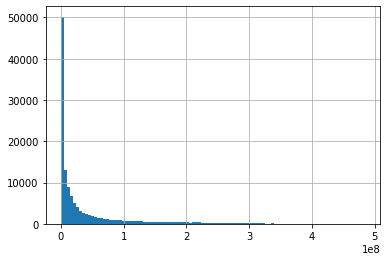

In [18]:
# Distribution
df['time_diff'].dt.total_seconds().hist(bins=100)

In [34]:
# Solution for evaluating time between opening and closing issues
dataTime = list(db.event.aggregate([{
           '$lookup':
             {
               'from': 'issue',
               'localField': 'issue_id',
               'foreignField': '_id',
               'as': 'issue'
             }},
            {
            '$unwind': '$issue'
            },
            {
            '$project': {
                '_id': 1, 
                'old_value': 1,  
                'new_value': 1, 
                'created_at': 1,
                'issue_id': '$issue._id',
                'issue_created_at': '$issue.created_at',
            }
            }
        ]))

dfTime = pd.DataFrame(dataTime)
print(len(dfTime.index))
dfTime.head()

1290480


,_id,created_at,new_value,issue_id,issue_created_at,old_value
0,58bfca930ccb2667fe269dd5,2008-06-17 14:57:32.125,java client,58bfca930ccb2667fe269dd4,2008-06-17 14:56:48.591,NaN
1,58bfca930ccb2667fe269dd6,2008-06-17 14:57:32.125,c client,58bfca930ccb2667fe269dd4,2008-06-17 14:56:48.591,NaN
2,58bfca950ccb2667fe269dd9,2008-06-27 14:57:40.462,Resolved,58bfca950ccb2667fe269dd8,2008-06-18 21:45:37.853,Open
3,58bfca950ccb2667fe269dda,2008-06-27 14:57:40.462,Invalid,58bfca950ccb2667fe269dd8,2008-06-18 21:45:37.853,NaN
4,58bfca950ccb2667fe269ddf,2008-07-22 17:46:24.481,Won't Fix,58bfca950ccb2667fe269dde,2008-07-04 01:51:27.937,NaN


In [46]:
from datetime import timedelta
# put all new value strings in lowercase
dfTime['new_value'] = dfTime['new_value'].str.lower()
resolved_equivs = ['resolved','closed','fixed']

# We'll only look at closed and resolved issues
dfTime = dfTime[dfTime['new_value'].isin(resolved_equivs)]  # filter new values

dfTime['time_diff'] = dfTime['created_at'] - dfTime['issue_created_at']

dfTime = dfTime[dfTime['time_diff'] > timedelta(seconds=60)]  # filter out all issues closed within one minute

<AxesSubplot:>

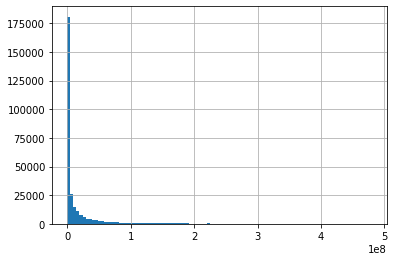

In [47]:
# Distribution
dfTime['time_diff'].dt.total_seconds().hist(bins=100)